<a href="https://colab.research.google.com/github/aditya-singam/shapclustering/blob/main/Pioneer_Research_Code_Aditya_Singampalli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
# Step 1: Download the MovieLens 100K Dataset
!pip install shap
!pip install umap-learn
!pip install category_encoders
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip


--2024-07-06 04:19:00--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  24.6MB/s    in 0.2s    

2024-07-06 04:19:01 (24.6 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [76]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from umap import UMAP
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import os

print(os.getcwd())


# Load MovieLens dataset
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None,
                     names=['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] +
                            ['genre_' + str(i) for i in range(19)])

# Merge ratings with movies to get genre information
data = pd.merge(ratings, movies, on='movieId')

# Step 1: Define a function to get the favorite genre for each user
def get_favorite_genre(user_data):
    high_rated = user_data[user_data['rating'] >= 4]
    # Select genre columns and ensure they are numeric
    genres = high_rated.iloc[:, 5:].apply(pd.to_numeric, errors='coerce').fillna(0)
    # Sum the genre columns
    genres_sum = genres.sum()
    # Ensure genres_sum is numeric
    genres_sum = pd.to_numeric(genres_sum, errors='coerce')
    # Find the genre with the highest sum
    return genres_sum.idxmax()

# Apply the function to get favorite genres
user_genres = data.groupby('userId').apply(get_favorite_genre).reset_index()
user_genres.columns = ['userId', 'favorite_genre']
#print(user_genres)

# Merge favorite genres back with user demographic data
users = pd.read_csv('ml-100k/u.user', sep='|', names=['userId', 'age', 'gender', 'occupation', 'zip_code'])
data = pd.merge(users, user_genres, on='userId')
# print(" ******** data after genere ")
# print(data.head())


# Convert categorical columns to numeric
data['gender'] = data['gender'].map({'M': 1, 'F': 2})
#data = pd.concat([data, pd.get_dummies(data['occupation'], prefix='occ')], axis=1)
label_encoder = LabelEncoder()
data['occupation'] = label_encoder.fit_transform(data['occupation'])
# data['zip_code'] = pd.to_numeric(data['zip_code'], errors='coerce').fillna(-1).astype(int)
data['zip_code'] = label_encoder.fit_transform(data['zip_code'])
# print(data.head())

X = data.drop(columns=['userId', 'favorite_genre'])

y = data['favorite_genre']
le = LabelEncoder()
y = le.fit_transform(y)


model = xgb.XGBClassifier()
model.fit(X, y)
y_pred = model.predict(X)

# print(y)
# print(y_pred)
accuracy = accuracy_score(y,y_pred)
print(f"Accuracy: {accuracy:.2f}")

/content
Accuracy: 0.99


<built-in method count of str object at 0x78b963abc2f0>
**length**
3772
****
(943, 4, 10)
[[-0.50702584 -1.1111538  -1.110152   -0.74802965  0.239706   -0.2575424
  -1.0387884  -1.1553484   0.1165474  -0.1563828 ]
 [ 0.29177523 -0.3290799  -1.4917305   0.09040887  0.0545909   0.
  -0.66436875 -0.6609882   0.01527588 -0.35460955]
 [-0.35940835 -0.3987779  -0.66751057 -0.16237062 -0.07258318 -0.44877502
   0.14330658 -1.7107618   0.15623204 -0.18325458]
 [-0.04470412 -2.0152733  -1.4574815  -2.1145303  -0.9789373  -0.37159967
   0.19531427  0.64259607 -0.5854145   0.04234291]]
*************
age



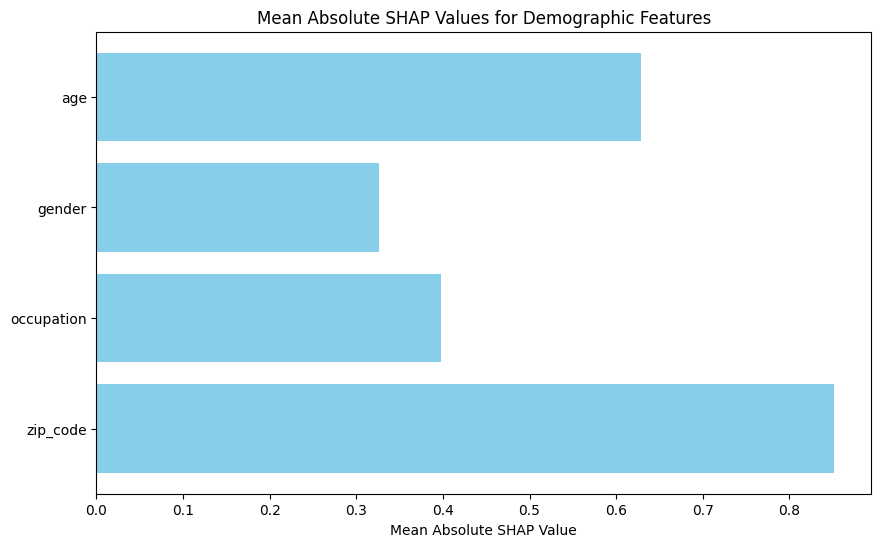

      feature  mean_abs_shap
0         age       0.628747
1      gender       0.325873
2  occupation       0.397949
3    zip_code       0.851955


In [56]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# Step 4: Calculate SHAP Values
explainer = shap.Explainer(model)
print(explainer.model_output.count)
print("**length**")
print(X.size)
shap_values = explainer.shap_values(X, check_additivity=False)
print("****")
print(shap_values.data)
print(shap_values.shape)
print(shap_values[0])
# Step 5: Calculate the mean absolute SHAP value for each demographic feature
demographic_features = ['age', 'gender', "zip_code", "occupation"]
shap_values_demographic = np.abs(shap_values).mean(axis=0)  # Calculate mean absolute SHAP values

print("*************")
print(X.columns[0])

shap_df_demographic = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': shap_values_demographic.mean(axis=1) # Take mean across classes to get single value per feature
})
print()

# Filter for just the demographic features
shap_df_demographic = shap_df_demographic[shap_df_demographic['feature'].isin(demographic_features)]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(shap_df_demographic['feature'], shap_df_demographic['mean_abs_shap'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Mean Absolute SHAP Values for Demographic Features')
plt.gca().invert_yaxis()
plt.show()

scaler = MinMaxScaler()
normalized_shap_values = scaler.fit_transform(shap_df_demographic['mean_abs_shap'].values.reshape(-1, 1)).flatten()

# Create weighted features
weighted_features = X[demographic_features] * normalized_shap_values

#shap_df_demographic = pd.DataFrame({'feature': X_train.columns, 'mean_abs_shap': shap_values_demographic[0]})
print(shap_df_demographic)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[8 8 8 4 7 8 8 0 8 8 8 8 8 8 8 8 8 8 7 0 1 0 8 8 7 8 8 4 8 7 8 8 4 8 4 8 0
 7 8 8 7 8 7 8 7 8 8 8 7 8 0 8 0 0 0 0 7 8 8 8 8 8 8 8 8 8 0 8 8 0 8 8 8 8
 7 8 8 7 8 8 8 8 7 8 8 8 7 8 8 8 8 8 7 8 8 8 3 7 8 8 0 3 0 8 8 8 8 8 0 8 8
 8 8 8 8 8 0 8 8 8 8 8 8 4 7 8 0 8 8 0 8 8 8 0 8 8 0 8 8 8 4 7 4 8 8 8 8 7
 8 8 8 2 8 8 8 8 8 0 7 8 8 0 8 4 8 0 8 7 0 4 8 7 8 8 8 8 8 8 8 8 8 8 0 8 8
 4 8 8 8 8 8 8 8 8 8 7 0 8 8 0 8 7 8 8 8 8 8 7 7 7 8 8 8 8 8 8 0 4 8 8 8 8
 7 8 8 8 8 8 8 8 0 8 8 8 8 8 8 0 8 8 8 8 8 8 0 7 8 0 8 8 8 8 8 0 1 0 8 8 8
 0 4 8 8 7 4 8 0 8 8 8 8 8 8 8 0 8 8 8 7 8 4 8 7 8 8 7 8 8 0 0 8 8 8 0 8 8
 8 8 8 7 0 0 7 2 8 8 7 8 0 5 8 8 8 8 8 8 4 8 8 0 8 8 8 8 8 8 8 8 8 7 8 0 7
 8 4 7 0 8 8 7 8 8 8 8 8 0 8 8 8 8 8 0 8 8 4 8 0 8 0 8 8 4 7 8 8 1 1 0 8 8
 8 4 8 8 4 8 8 8 8 8 8 8 8 4 8 0 8 4 8 8 8 8 7 0 8 4 8 8 8 0 8 8 0 8 8 8 7
 8 8 8 0 8 8 8 4 8 8 4 2 8 4 8 8 8 0 8 8 8 8 8 4 8 8 7 7 8 8 0 8 8 0 0 8 8
 8 8 8 8 8 8 4 8 8 8 8 8 8 8 0 8 8 8 8 4 8 0 8 8 8 8 6 0 8 8 7 7 2 7 8 8 7
 0 0 0 7 8 8 8 4 8 8 8 0 

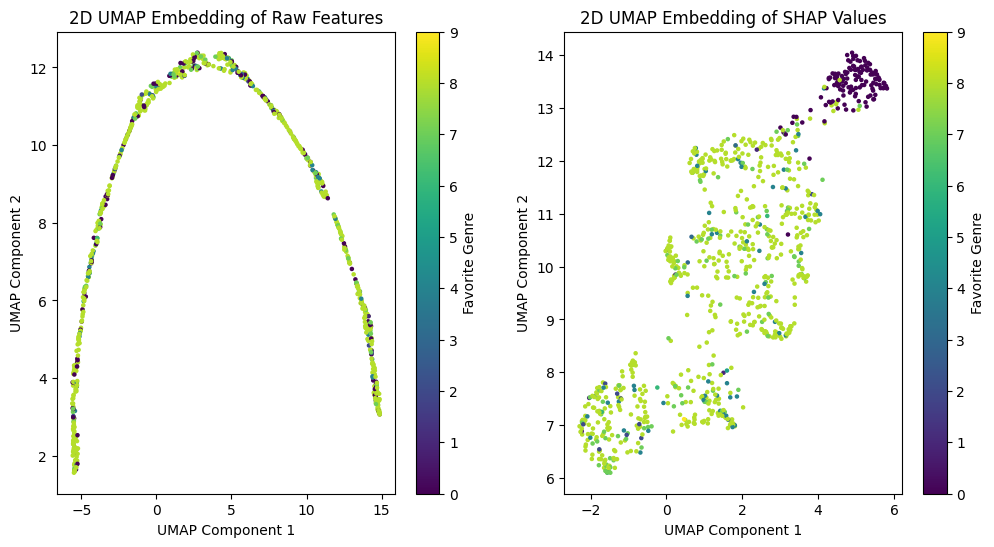

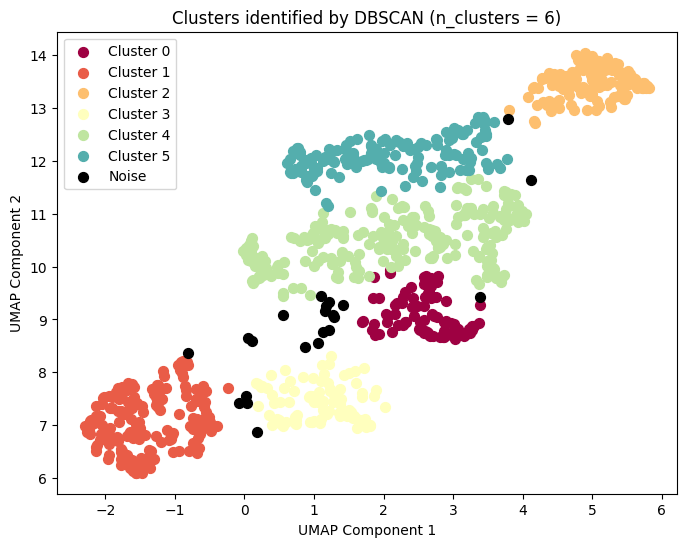

x2_labels: 
[ 0  0  1  5  2  0  0  2  2  0  1  2  3  4  0  2  2  1  2  0  1  1  5  0
  4  3  3  4  0  4  2  0  3  5  1  0  4  4  2  3  0  2  2  5  5  5  2  2
  0  5  2  4  4  6  2  5  0  5  2  2  1  0  6  5  5  0  4  3  4  4  0  6
  1  0  2  2  3  6  2  5  3  3  5  4  2  5  0  2  6  0  2  0  3  6  2  6
  0  0  6  0  2  1  4  4  0  4  6  6  4  0  0  6  0  6  2  0  2  0  6  2
  0  3  2  6  3  2  6  2  2  4  2  0  0  0  1  0  0  4  2  1  1  5  2  3
  0  0  2  0  2  2  5  6  6  4  2  2  6  3  4  6  4  2  0  0  4  4  0  0
  4  1  0  3  3  5  3  2  2  5  2  4  3  1  3  6  0  2  2  3  0  0  0  0
  5  2  0  4  6  4  2  0  0  6  1  2  2  5  0  2  0  2  1  6  4  2  6  2
  2  2  5  0  2  3  5  5  4  0  6  3  3  2  2  0  0  0  3  4  6  5  0  2
  2  1  4  0  4  3  2  1  0  0  0  2  3  5  2  1  0  0  5  0  0  0  4  0
  0  0  0  2  5  6  3  4  2  4  0  0  4  3  0  3  2  2  4  0  4  2  1  3
  0  0  5  0  6  0  5  2  0  2  6  4  4  0  2  6  0  6  4  0  6  0  6  2
  4  2  2 -1  2  2  3  3  4  5  2  2  2

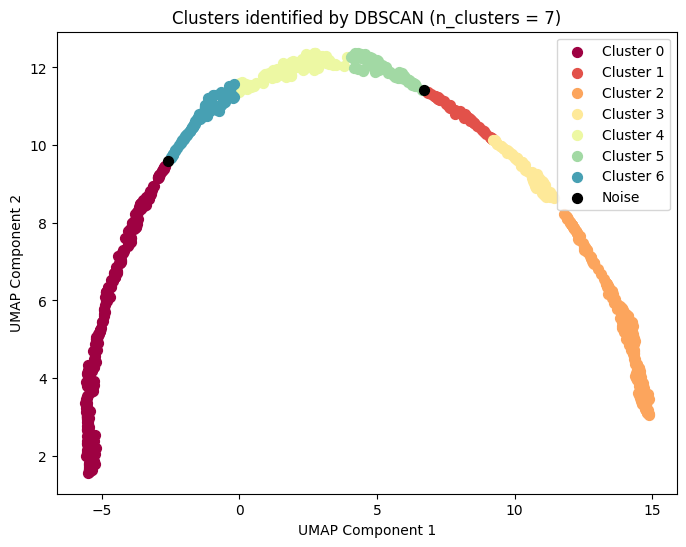

In [63]:
# Perform clustering
# n_clusters = 5
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# clusters = kmeans.fit_predict(weighted_features)

# dbscan = DBSCAN(eps=1.5, min_samples=20)
# clusters = dbscan.fit_predict(weighted_features)

# Visualize clusters using UMAP and DBSCAN
X_2d = UMAP(n_components=2, n_neighbors=200, min_dist=0, random_state = 43).fit_transform(X)
s_2d = UMAP(n_components=2, n_neighbors=200, min_dist=0, random_state = 43).fit_transform(shap_values[:, :, 0])

# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
y_numeric = le.fit_transform(y)
print(y)



# Plotting the 2D embedding of raw variable values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_numeric, cmap='viridis', s=5)
plt.title('2D UMAP Embedding of Raw Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Favorite Genre')


# Plotting the 2D embedding of SHAP values
plt.subplot(1, 2, 2)
print("*****s_2d****")
print(s_2d[:, 0])
print("*****s_2d1****")
print(s_2d[:, 1])
plt.scatter(s_2d[:, 0], s_2d[:, 1], c=y_numeric, cmap='viridis', s=5)
plt.title('2D UMAP Embedding of SHAP Values')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Favorite Genre')

x_labels = DBSCAN(eps=0.58, min_samples=40).fit(s_2d).labels_
print("x_labels: ")
print(x_labels)
plt.figure(figsize=(8, 6))
unique_labels2 = set(x_labels)
print("unique_labels2: ")
print(unique_labels2)
n_clusters = len(unique_labels2) - (1 if -1 in unique_labels2 else 0)
colors2 = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels2)))
#print(unique_labels)
#print(colors)
for k, col in zip(unique_labels2, colors2):
    #print(k)
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (x_labels == k)
    xy = s_2d[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=50, label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title(f'Clusters identified by DBSCAN (n_clusters = {n_clusters})')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

x2_labels = DBSCAN(eps=0.78, min_samples=40).fit(X_2d).labels_
print("x2_labels: ")
print(x2_labels)
plt.figure(figsize=(8, 6))
unique_labels = set(x2_labels)
print("unique_labels: ")
print(unique_labels)
n_clusters_2 = len(unique_labels) - (1 if -1 in unique_labels else 0)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
#print(unique_labels)
#print(colors
for k, col in zip(unique_labels, colors):
    #print(k)
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (x2_labels == k)
    xy = X_2d[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=50, label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title(f'Clusters identified by DBSCAN (n_clusters = {n_clusters_2})')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

In [64]:
from sklearn.metrics.pairwise import cosine_similarity
clusters = x_labels
clusters2 = x2_labels
data['cluster'] = clusters
data['cluster2'] = clusters2
print(data['cluster'].head())
# Prepare user-item matrix for each cluster
def create_user_item_matrix(ratings, cluster_users):
    user_item_matrix = ratings[ratings['userId'].isin(cluster_users)].pivot(index='userId', columns='movieId', values='rating')
    return user_item_matrix

# Split ratings into clusters
cluster_ratings = {}
for cluster in set(clusters):
    if cluster == -1:  # Skip noise points
        continue
    cluster_users = data[data['cluster'] == cluster]['userId']
    cluster_ratings[cluster] = create_user_item_matrix(ratings, cluster_users)

cluster_ratings2 = {}
for cluster in set(clusters2):
    if cluster == -1:  # Skip noise points
        continue
    cluster_users2 = data[data['cluster2'] == cluster]['userId']
    cluster_ratings2[cluster] = create_user_item_matrix(ratings, cluster_users2)


0    4
1    0
2    5
3    0
4    1
Name: cluster, dtype: int64


In [65]:
# Calculating Cosine similarity
cluster_similarities = {}
for cluster, user_item_matrix in cluster_ratings.items():
    similarity_matrix = cosine_similarity(user_item_matrix.fillna(0))  # Fill NA with 0 for similarity calculation
    cluster_similarities[cluster] = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

cluster_similarities2 = {}
for cluster2, user_item_matrix2 in cluster_ratings2.items():
    similarity_matrix2 = cosine_similarity(user_item_matrix2.fillna(0))  # Fill NA with 0 for similarity calculation
    cluster_similarities2[cluster2] = pd.DataFrame(similarity_matrix2, index=user_item_matrix2.index, columns=user_item_matrix2.index)


In [74]:
def predict_rating(userId, movieId, cluster, cluster_ratings, cluster_similarities):
    user_item_matrix = cluster_ratings.get(cluster, None)
    similarity_matrix = cluster_similarities.get(cluster, None)

    if user_item_matrix is None or similarity_matrix is None:
        return None

    # Check if the user and movie are in the cluster
    if userId not in user_item_matrix.index or movieId not in user_item_matrix.columns:
        return None

    # Get the similarity scores for the user
    sim_scores = similarity_matrix[userId]
    print("****sim_scores***")
    print(sim_scores)
    # Get the ratings for the movie
    movie_ratings = user_item_matrix[movieId]
    print("****movie_id***")
    print(movieId, " ", movie_ratings)
    # Calculate the weighted average rating
    weighted_sum = np.dot(sim_scores, movie_ratings.fillna(0))
    print("****weighted_sum***")
    print(weighted_sum)
    sum_of_weights = np.sum(sim_scores[movie_ratings.notna()])
    print("****sum_of_weights***")
    print(sum_of_weights)
    if sum_of_weights == 0:
        return None

    predicted_rating = weighted_sum / sum_of_weights
    return predicted_rating

cluster = data[data['userId'] == 1]['cluster'].values[0]
predicted_rating = predict_rating(1, 202, cluster,cluster_ratings, cluster_similarities)
print(predicted_rating)
print(f"Predicted Rating for User 1 on Movie 202: {predicted_rating:.2f}")

cluster2 = data[data['userId'] == 1]['cluster2'].values[0]
print(cluster2)
predicted_rating2 = predict_rating(1, 202, cluster2, cluster_ratings2, cluster_similarities2)
print(f"Predicted Rating for User 1 on Movie 202: {predicted_rating2:.2f}")

****sim_scores***
userId
1      1.000000
6      0.430239
9      0.078138
14     0.332107
16     0.403987
         ...   
926    0.083955
933    0.490353
935    0.119482
936    0.274876
937    0.189705
Name: 1, Length: 248, dtype: float64
****movie_id***
202   userId
1      5.0
6      3.0
9      NaN
14     3.0
16     5.0
      ... 
926    NaN
933    2.0
935    NaN
936    NaN
937    NaN
Name: 202, Length: 248, dtype: float64
****weighted_sum***
118.37641448409587
****sum_of_weights***
30.98813087140301
3.820056620237718
Predicted Rating for User 1 on Movie 202: 3.82
0
****sim_scores***
userId
1      1.000000
2      0.166931
6      0.430239
7      0.440367
10     0.376544
         ...   
923    0.158199
937    0.189705
941    0.148617
942    0.179508
943    0.398175
Name: 1, Length: 283, dtype: float64
****movie_id***
202   userId
1      5.0
2      NaN
6      3.0
7      3.0
10     NaN
      ... 
923    NaN
937    NaN
941    NaN
942    NaN
943    2.0
Name: 202, Length: 283, dtype: float64


In [67]:
def predict_all_unseen_ratings(userId, cluster, cluster_ratings, cluster_similarities):
    # Get the user's rated movies
    user_rated_movies = ratings[ratings['userId'] == userId]['movieId'].tolist()

    # Get all movies
    all_movies = ratings['movieId'].unique()

    # Predict ratings for unseen movies
    unseen_movie_ratings = []
    for movieId in all_movies:
        if movieId not in user_rated_movies:
            predicted_rating = predict_rating(userId, movieId, cluster, cluster_ratings, cluster_similarities)
            if predicted_rating is not None:
                unseen_movie_ratings.append((movieId, predicted_rating))

    return unseen_movie_ratings

In [68]:
def rank_movies(predicted_ratings):
    return sorted(predicted_ratings, key=lambda x: x[1], reverse=True)

def recommend_top_movies(userId, cluster, cluster_ratings, cluster_similarities ):
    predicted_ratings = predict_all_unseen_ratings(userId, cluster,cluster_ratings, cluster_similarities)
    ranked_movies = rank_movies(predicted_ratings)
    top_movies = ranked_movies[:5]

    # Get movie titles
    top_movie_titles = [movies[movies['movieId'] == movie[0]]['title'].values[0] for movie in top_movies]

    return top_movie_titles

user_id = 1
user_cluster = data[data['userId'] == user_id]['cluster'].values[0]
recommended_movies = recommend_top_movies(user_id, user_cluster, cluster_ratings, cluster_similarities)
print(f"Top 5 recommended movies for User {user_id}:")
for i, movie in enumerate(recommended_movies, 1):
    print(f"{i}. {movie}")

user_cluster2 = data[data['userId'] == user_id]['cluster2'].values[0]
recommended_movies2 = recommend_top_movies(user_id, user_cluster2, cluster_ratings2, cluster_similarities2)
print(f"Top 5 recommended movies for User {user_id}:")
for i, movie in enumerate(recommended_movies2, 1):
    print(f"{i}. {movie}")

Top 5 recommended movies for User 1:
1. Faithful (1996)
2. Stalingrad (1993)
3. Critical Care (1997)
4. Delta of Venus (1994)
5. Prefontaine (1997)
Top 5 recommended movies for User 1:
1. Prefontaine (1997)
2. Delta of Venus (1994)
3. Santa with Muscles (1996)
4. Mina Tannenbaum (1994)
5. Faust (1994)


In [69]:
from sklearn.model_selection import train_test_split

def train_test_split_ratings(ratings, test_size=0.2):
    train_data = []
    test_data = []

    for user, group in ratings.groupby('userId'):
        n = len(group)
        if n == 1:
            train_data.append(group)
        else:
            train_group, test_group = train_test_split(group, test_size=test_size, random_state=42)
            train_data.append(train_group)
            test_data.append(test_group)

    train_data = pd.concat(train_data)
    test_data = pd.concat(test_data)

    # Add cluster information to train and test data if it exists in original ratings
    # Check for both 'cluster' and 'cluster2' columns
    if 'cluster' in ratings.columns:
        train_data = train_data.merge(ratings[['userId', 'cluster']], on='userId', how='left')
        test_data = test_data.merge(ratings[['userId', 'cluster']], on='userId', how='left')
    if 'cluster2' in ratings.columns: # Add this condition to handle 'cluster2'
        train_data = train_data.merge(ratings[['userId', 'cluster2']], on='userId', how='left')
        test_data = test_data.merge(ratings[['userId', 'cluster2']], on='userId', how='left')
    else: # Handle the case where neither 'cluster' nor 'cluster2' are in original ratings
        # Assuming 'data' DataFrame contains cluster information
        train_data = train_data.merge(data[['userId', 'cluster']], on='userId', how='left')
        test_data = test_data.merge(data[['userId', 'cluster']], on='userId', how='left')
        if 'cluster2' in data.columns: # Add this condition to handle 'cluster2' in 'data'
            train_data = train_data.merge(data[['userId', 'cluster2']], on='userId', how='left')
            test_data = test_data.merge(data[['userId', 'cluster2']], on='userId', how='left')

    return train_data, test_data

train_ratings, test_ratings = train_test_split_ratings(ratings) # Recreate train and test sets

In [70]:
def predict_ratings_for_test_set(test_ratings, clusters, train_ratings,cluster_ratings, cluster_similarities):
    predictions = []

    for _, row in test_ratings.iterrows():
        userId = row['userId']
        movieId = row['movieId']
        true_rating = row['rating']

        # Check if user exists in train_ratings before accessing cluster
        user_in_train = train_ratings[train_ratings['userId'] == userId]
        if not user_in_train.empty:
            # Get the cluster for the user directly from the train_ratings DataFrame
            user_cluster = train_ratings[train_ratings['userId'] == userId]['cluster'].values[0]
            predicted_rating = predict_rating(userId, movieId, user_cluster, cluster_ratings, cluster_similarities)

            if predicted_rating is not None:
                predictions.append((true_rating, predicted_rating))

    return predictions


# Pass train_ratings to the function
predictions = predict_ratings_for_test_set(test_ratings, clusters, train_ratings, cluster_ratings, cluster_similarities)
predictions2 = predict_ratings_for_test_set(test_ratings, clusters2, train_ratings, cluster_ratings2, cluster_similarities2)

RMSE: 0.8446
MAE: 0.6634
RMSE2: 0.7946
MAE2: 0.6191


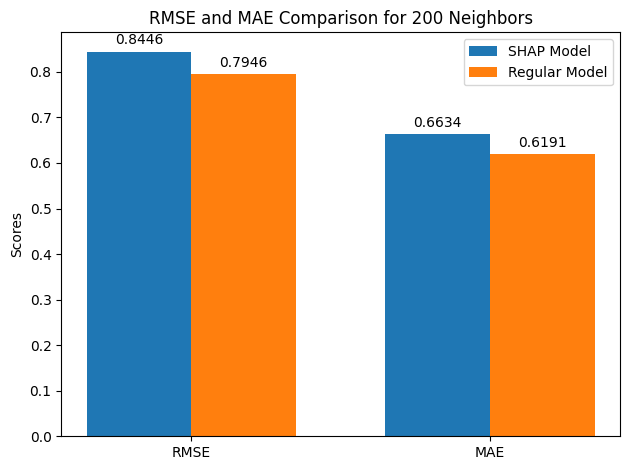

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_rmse_mae(predictions):
    true_ratings = [pred[0] for pred in predictions]
    predicted_ratings = [pred[1] for pred in predictions]

    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    mae = mean_absolute_error(true_ratings, predicted_ratings)

    return rmse, mae

rmse, mae = calculate_rmse_mae(predictions)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

rmse2, mae2 = calculate_rmse_mae(predictions2)
print(f"RMSE2: {rmse2:.4f}")
print(f"MAE2: {mae2:.4f}")


# Visualize RMSE and MAE
labels = ['RMSE', 'MAE']
results1 = [rmse, mae]
results2 = [rmse2, mae2]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, results1, width, label='SHAP Model')
rects2 = ax.bar(x + width/2, results2, width, label='Regular Model')

ax.set_ylabel('Scores')
ax.set_title('RMSE and MAE Comparison for 200 Neighbors')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()